## Analysis of PTNs


**Key Findings:**
- MPS distribution correctly learns a gaussian
- Gradients vanish as horizon increased
- Images dist lower rank than language dist
- Using exp required longer training (50 epochs vs 10)
- Abs is more robust to rank vs exp
- In language modelling, after fitting fully to two examples, all interpolated examples are equally likely. But interpolated sentences are gibberish

**Ideas:**
- (Vanishing gradient) when updating the kth core replace all cores ata distance of 5 away with identity mats
- (Vanishing gradient) orthogonal parameterization of 50% of the cores


**Claims/Theories**:
- MPS does poorly on language because it assigns high probability to linear combinations of examples. But because the examples are discrete, their linear combination is not meaningful. In contrast, assigning high probability to linear combinations of vector representations of images is more acceptable. That's why we can get reasonable NLL values for training on text but when we sample we often run into the interpolated text which ends up looking like gibberish

### Fitting a gaussian distribution with MPS

In [1]:
import torch

class SyntheticDataset(torch.utils.data.Dataset):
    def __init__(self, n_samples: int, d_output: int = 256, horizon: int = 2):
        self.n_samples = n_samples
        self.d_output = d_output
        self.horizon = horizon

        # Use smaller sigma so values rarely exceed [0, 1]
        sigma = 0.15  # tune this (0.1–0.2 usually works well)
        samples = torch.randn(n_samples, horizon) * sigma + 0.5

        # Discretize to [0, d_output - 1]
        samples = (samples * d_output).clamp(0, d_output - 1).round().to(torch.long)

        self.samples = samples

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx: int):
        return self.samples[idx]


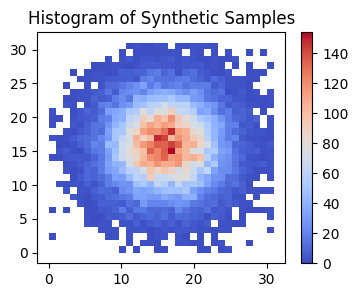

Sample shape: (20000, 2)


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_samples(samples, title="Histogram of Synthetic Samples", x_idx=0, y_idx=1):
    plt.figure(figsize=(4, 3))
    sns.histplot(x=samples[:,x_idx], y=samples[:,y_idx], bins=32, cbar=True, cmap="coolwarm")
    plt.title(title)
    plt.show()


# Hyperparameters
d_model = 1
# Regular 
# d_output = 256
# horizon = 8
# If you want to materialize
d_output = 32
horizon = 2
rank = 2
n_samples = 20_000
n_test_samples = 20_000

dataset = SyntheticDataset(n_samples, d_output=d_output, horizon=horizon).samples.numpy()
plot_samples(dataset)
print("Sample shape:", dataset.shape)



In [3]:
from ptn.dists import dists
from ptn.dists._abc import AbstractDisributionHeadConfig
model = dists['mps_bm_lsf'](
    AbstractDisributionHeadConfig(
        d_model=d_model,
        d_output=d_output,
        horizon=horizon,
        rank=rank,
        # pos_func="abs",
        # mode="direct",
        init_method="ortho",
    )
)
generated_rand = model.generate(torch.ones(n_test_samples, 1))

In [7]:
# Train model

# Hyperparameters
n_epochs = 5
batch_size = 128
lr = 1e-3

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
grads = []
losses = []
for epoch in range(n_epochs):
    train_losses = []
    for i, batch in enumerate(dataloader):
        output = model(torch.ones(batch.size(0), 1), batch)
        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()
        grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))
        train_losses.append(output.loss.item())
    loss_avg = sum(train_losses)/len(train_losses)
    losses.append(loss_avg)
    print(f"[Epoch {epoch+1}/{n_epochs}] Loss: {loss_avg:.2f}")



/var/folders/r_/d81gvkws1n5fg2_7mb57cwzh0000gn/T/ipykernel_30237/199699006.py:19: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))


[Epoch 1/5] Loss: 2.56
[Epoch 2/5] Loss: 2.22
[Epoch 3/5] Loss: 1.97
[Epoch 4/5] Loss: 1.76
[Epoch 5/5] Loss: 1.58


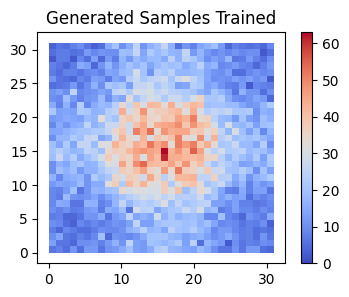

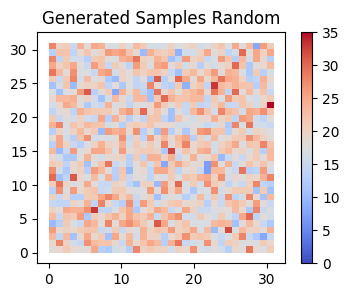

In [9]:
generated_trained = model.generate(torch.ones(n_test_samples, 1))

# Plot generated_trained and generated_rand
plot_samples(generated_trained.numpy(), "Generated Samples Trained")
plot_samples(generated_rand.numpy(), "Generated Samples Random")

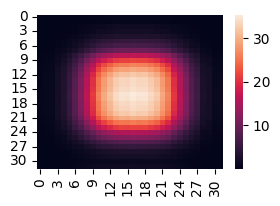

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
if hasattr(model, 'materialize') and horizon == 2: # only materialize for horizon 2
    p = model.materialize(torch.ones(1, 1)).reshape(d_output, d_output).detach().numpy()
    plt.figure(figsize=(3, 2))  # Set a small figure size
    sns.heatmap(p)
    plt.show()

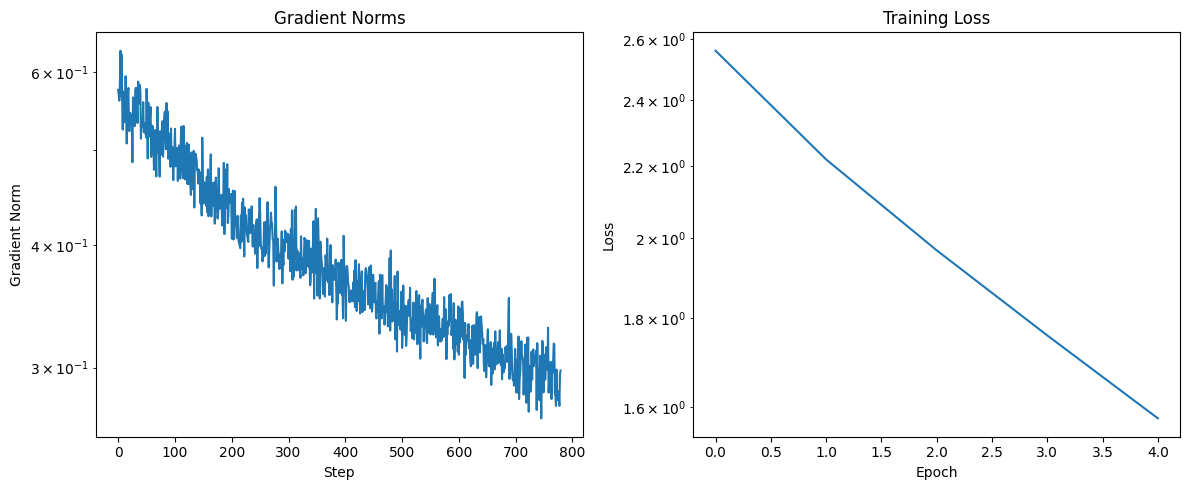

In [12]:
# Plot grads and losses side by side using matplotlib and seaborn
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot grads
sns.lineplot(x=range(len(grads)), y=torch.tensor(grads).tolist(), ax=axes[0])
axes[0].set_title("Gradient Norms")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Gradient Norm")
axes[0].set_yscale('log')  # Set log scale before plotting

# Plot losses
sns.lineplot(x=range(len(losses)), y=losses, ax=axes[1])
axes[1].set_title("Training Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_yscale('log')  # Set log scale before plotting

plt.tight_layout()
plt.show()


### Gradient vanishing problem in MPS

In [13]:
# Compare different horizons
import itertools
import torch
from tqdm import tqdm
from ptn.dists import dists
from ptn.dists._abc import AbstractDisributionHeadConfig

# Hyperparameters
d_model = 1
d_output = 2
rank = 2
n_epochs = 10
n_samples = 20_000
batch_size = 32
lr = 1e-3
horizons = [8, 32]
modes = ["direct", "residual"]
pos_funcs = ["abs", "exp", "sigmoid"]
init_methods = ["ortho", "randn"]
model_names = ['mps_sigma_lsf']

records = []  

def flatten(lst: list[torch.Tensor]) -> torch.Tensor:
    # Filter out None values
    lst = [l for l in lst if l is not None]
    return torch.cat([l.detach().flatten() for l in lst])

for mode, horizon, pos_func, init_method, md in tqdm(itertools.product(modes, horizons, pos_funcs, init_methods, model_names)):
    dataset = SyntheticDataset(n_samples, d_output=d_output, horizon=horizon).samples.numpy()
    model = dists[md](
        AbstractDisributionHeadConfig(
            d_model=d_model,
            d_output=d_output,
            horizon=horizon,
            rank=rank,
            mode=mode,
            pos_func=pos_func,
            init_method=init_method,
        )
    )

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        train_losses = []
        for i, batch in enumerate(dataloader):
            n = epoch * len(dataloader) + i  # iteration number
            output = model(torch.ones(batch.size(0), 1), batch)
            optimizer.zero_grad()
            output.loss.backward()
            rec = {
                "mode": mode,
                "horizon": horizon, 
                "init_method": init_method,
                "pos_func": pos_func,
                "iter": n, 
                "grad_norm": torch.nn.utils.clip_grad_norm(model.parameters(), 1.0).item(),
                "param_norm": torch.nn.utils.parameters_to_vector(model.parameters()).norm().item(),
                "loss": output.loss.item()
            }
            records.append(rec)
            optimizer.step()
            train_losses.append(output.loss.item())
        loss_avg = sum(train_losses)/len(train_losses)
        records.append({ **rec, "loss_avg": loss_avg })
        # print(f"[Epoch {epoch+1}/{n_epochs}] Loss: {loss_avg:.2f}")



/var/folders/r_/d81gvkws1n5fg2_7mb57cwzh0000gn/T/ipykernel_37870/80504003.py:58: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  "grad_norm": torch.nn.utils.clip_grad_norm(model.parameters(), 1.0).item(),


[Epoch 1/10] Loss: 0.35
[Epoch 2/10] Loss: 0.19
[Epoch 3/10] Loss: 0.19
[Epoch 4/10] Loss: 0.19
[Epoch 5/10] Loss: 0.19
[Epoch 6/10] Loss: 0.19
[Epoch 7/10] Loss: 0.19
[Epoch 8/10] Loss: 0.19
[Epoch 9/10] Loss: 0.19
[Epoch 10/10] Loss: 0.19
[Epoch 1/10] Loss: 0.50
[Epoch 2/10] Loss: 0.22
[Epoch 3/10] Loss: 0.19
[Epoch 4/10] Loss: 0.19
[Epoch 5/10] Loss: 0.19
[Epoch 6/10] Loss: 0.19
[Epoch 7/10] Loss: 0.19
[Epoch 8/10] Loss: 0.19
[Epoch 9/10] Loss: 0.19
[Epoch 10/10] Loss: 0.19
[Epoch 1/10] Loss: 0.39
[Epoch 2/10] Loss: 0.22
[Epoch 3/10] Loss: 0.20
[Epoch 4/10] Loss: 0.19
[Epoch 5/10] Loss: 0.19
[Epoch 6/10] Loss: 0.19
[Epoch 7/10] Loss: 0.19
[Epoch 8/10] Loss: 0.19
[Epoch 9/10] Loss: 0.19
[Epoch 10/10] Loss: 0.19
[Epoch 1/10] Loss: 0.70
[Epoch 2/10] Loss: 0.25
[Epoch 3/10] Loss: 0.20
[Epoch 4/10] Loss: 0.19
[Epoch 5/10] Loss: 0.19
[Epoch 6/10] Loss: 0.19
[Epoch 7/10] Loss: 0.19
[Epoch 8/10] Loss: 0.19
[Epoch 9/10] Loss: 0.19
[Epoch 10/10] Loss: 0.19
[Epoch 1/10] Loss: 0.53
[Epoch 2/10]

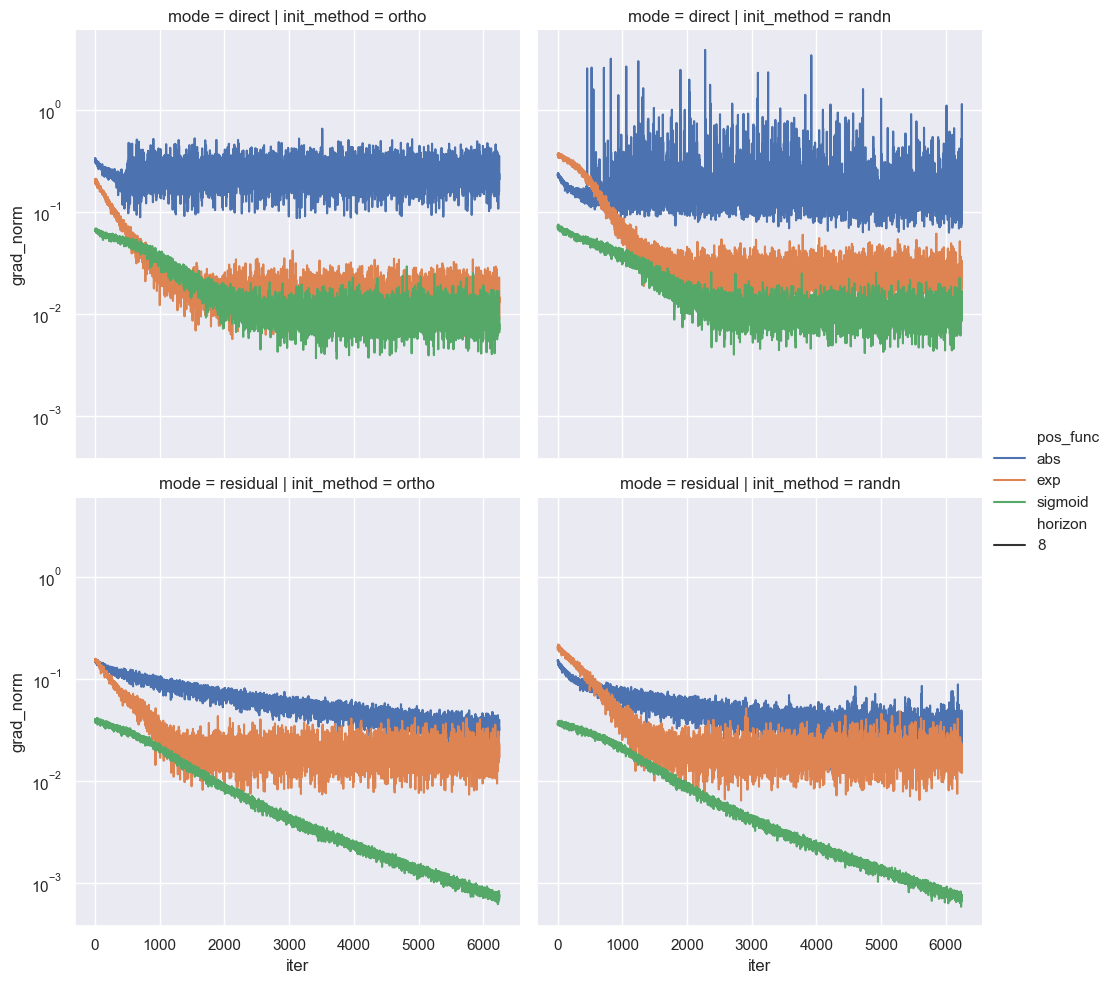

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert records_grads to a DataFrame for easy plotting
df_grads = pd.DataFrame(records)
sns.set_theme()

# Use a different color palette for hues
sns.relplot(
    data=df_grads,
    x="iter",
    y="grad_norm",
    kind="line",
    hue="pos_func",
    style="horizon",
    col="init_method",
    row="mode",
)
plt.yscale("log")  # Apply log scale to y-axis (may log scale)


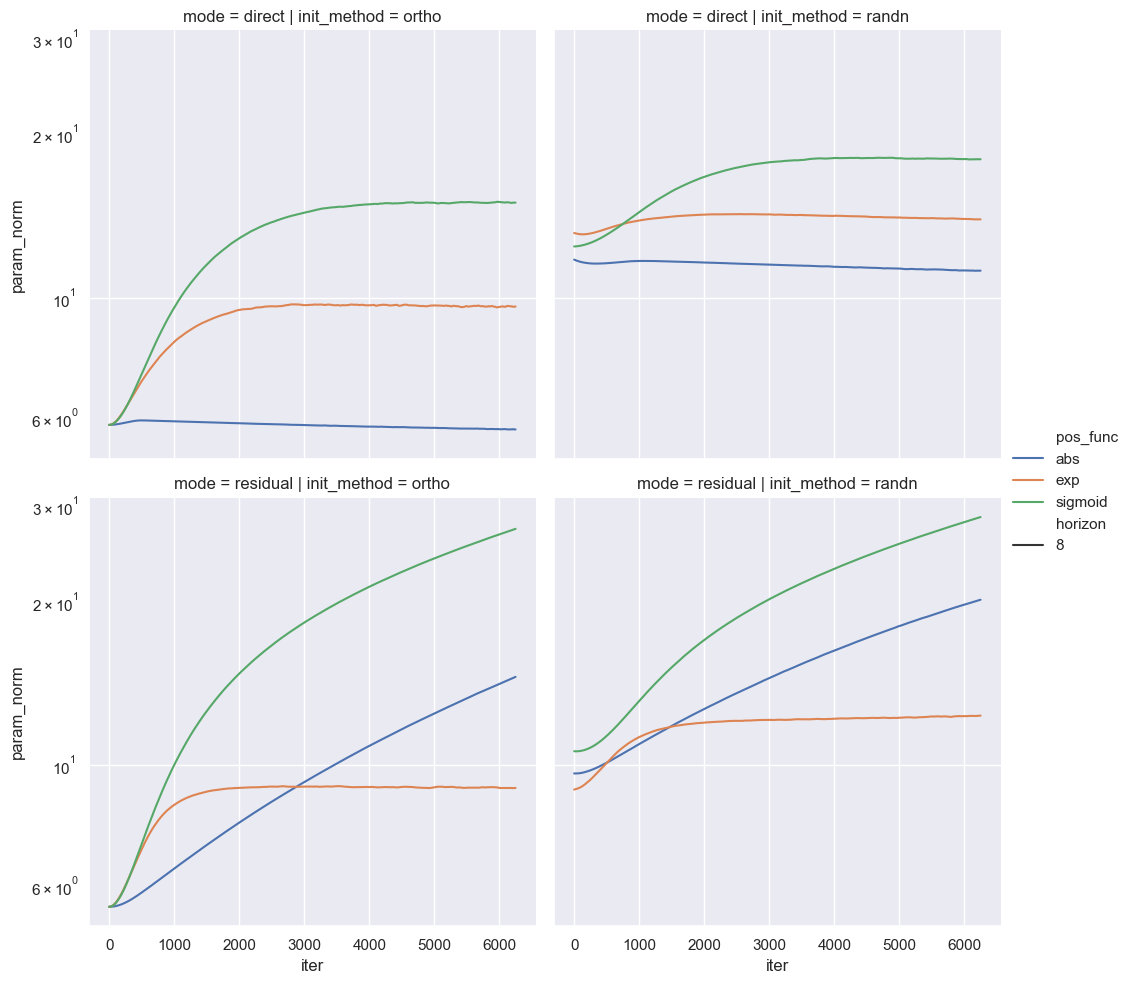

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert records_grads to a DataFrame for easy plotting
df_grads = pd.DataFrame(records)
sns.set_theme()

# Use a different color palette for hues
sns.relplot(
    data=df_grads,
    x="iter",
    y="param_norm",
    kind="line",
    hue="pos_func",
    style="horizon",
    col="init_method",
    row="mode",
)
plt.yscale("log")  # Apply log scale to y-axis (may log scale)


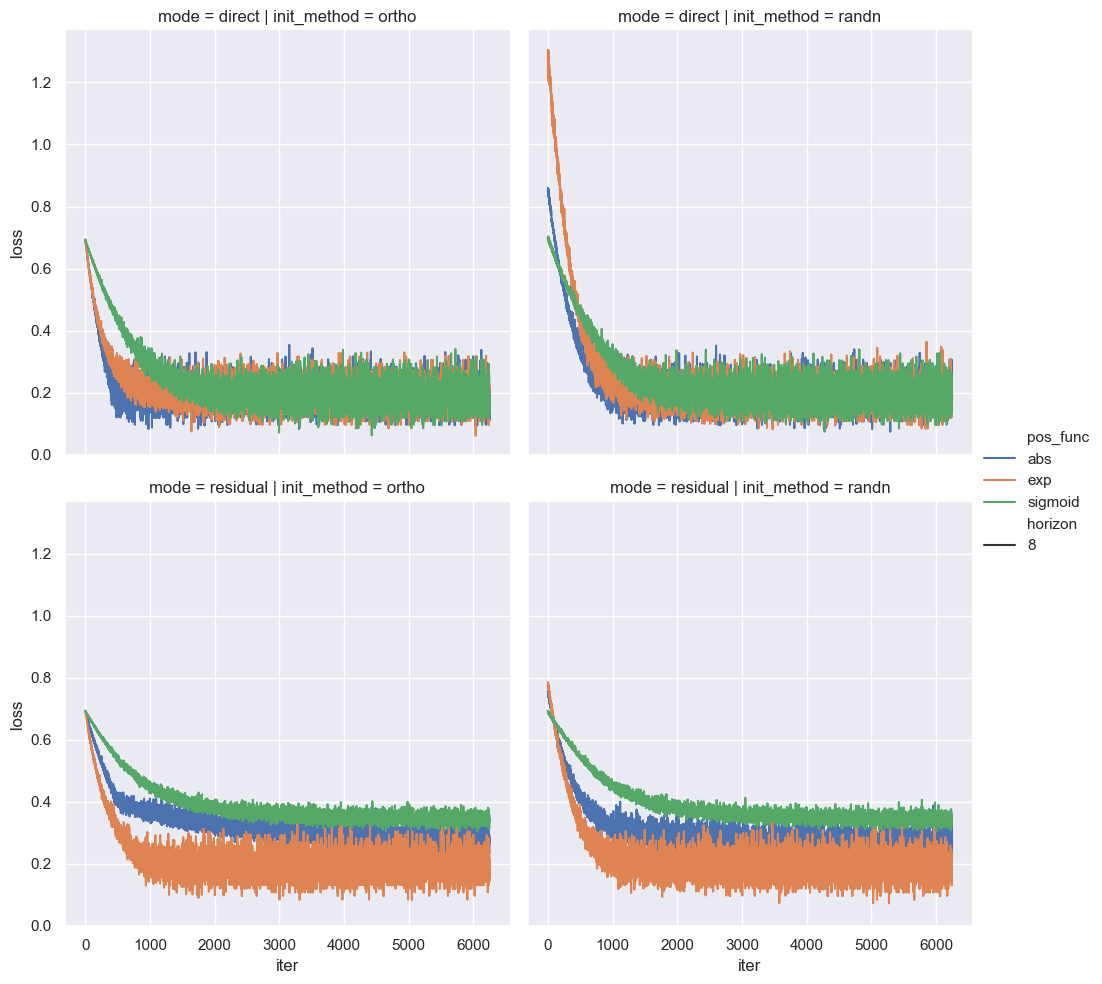

In [18]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert records_grads to a DataFrame for easy plotting
df_grads = pd.DataFrame(records)
sns.set_theme()

# Use a different color palette for hues
sns.relplot(
    data=df_grads,
    x="iter",
    y="loss",
    kind="line",
    hue="pos_func",
    style="horizon",
    col="init_method",
    row="mode",
)


### Fitting Discrete Distribution with MPS

#### Helpers

In [18]:
# Helper functions

import torch
import torchvision
from torchvision import transforms
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders, processors
import certifi
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

os.environ["SSL_CERT_FILE"] = certifi.where()


class ShakespeareDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        tokenizer,
        seq_len=256,
        max_samples=None,
        file_path="dataloaders/data/tinyshakespeare.txt",
    ):
        self.tokenizer = tokenizer
        self.seq_len = seq_len

        # Read Shakespeare text
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()

        # Tokenize the entire text
        tokens = self.tokenizer.encode(text)

        # Limit samples if specified
        if max_samples:
            tokens = tokens[: max_samples * seq_len]

        # Create sequences
        self.sequences = []
        for i in range(0, len(tokens) - seq_len, seq_len):
            seq = tokens[i : i + seq_len]
            if len(seq) == seq_len:
                self.sequences.append(seq)
        # for i in range(0, len(tokens) - seq_len, seq_len // 2):  # 50% overlap
        #     seq = tokens[i : i + seq_len]
        #     if len(seq) == seq_len:
        #         self.sequences.append(seq)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return {"input_ids": torch.tensor(seq, dtype=torch.long)}

class BPETokenizerWrapper:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.get_vocab_size()
        self.eos_token = "</s>"
        self.pad_token = "<pad>"
        self.eos_token_id = tokenizer.token_to_id(self.eos_token)
        self.pad_token_id = tokenizer.token_to_id(self.pad_token)

    def __len__(self):
        return self.vocab_size

    def encode(self, text, **kwargs):
        return self.tokenizer.encode(text).ids

    def decode(self, ids, skip_special_tokens=True):
        return self.tokenizer.decode(ids)

    def get_vocab_size(self):
        return self.vocab_size

def get_tokenizer(corpus_path, bit_size, n_bits_per_token):
    # You seem to want a specific vocab size tied to your later bin-coding:
    vocab_size = bit_size ** n_bits_per_token  # e.g., 2**8 = 256, 2**16 = 65536

    tok = Tokenizer(models.BPE(unk_token="<unk>"))
    tok.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
    tok.decoder = decoders.ByteLevel()
    tok.post_processor = processors.ByteLevel(trim_offsets=False)

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
        special_tokens=["<pad>", "<unk>", "<s>", "</s>"],
    )

    tok.train([corpus_path], trainer)
    return BPETokenizerWrapper(tok)

def dec2bin(x, bits):
    # mask = 2 ** torch.arange(bits).to(x.device, x.dtype)
    dv, dt = x.device, x.dtype
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(dv, dt)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).to(dt)

#### Categorical (Shakespeare, len=32)

In [19]:
# Helpers
import torch
from ptn.dists import dists
from ptn.dists._abc import AbstractDisributionHeadConfig

def dec2bin(x, bits):
    # mask = 2 ** torch.arange(bits).to(x.device, x.dtype)
    dv, dt = x.device, x.dtype
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(dv, dt)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).to(dt)

def bin2dec(b, bits):
    # note data type is important here and converted from int to float
    assert (
        b.size(-1) == bits
    ), f"Binary tensor last dimension must be of size {bits}"
    dv, dt = b.device, b.dtype
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(dv, dt)
    return torch.sum(mask * b, -1).to(dt)

In [24]:
# Hyperparameters
n_samples = 1000
seq_len = 32
batch_size = 32
bit_size = 512
n_bits_per_token = 1
# bit_size = 2
# n_bits_per_token = 9
file_path = "../data/shakespeare/main.txt"

tokenizer = get_tokenizer(corpus_path=file_path, bit_size=bit_size, n_bits_per_token=n_bits_per_token)
dataset = ShakespeareDataset(tokenizer, seq_len=seq_len, max_samples=n_samples+1, file_path=file_path)
print('Num. Tokens:', tokenizer.get_vocab_size())





Num. Tokens: 512


In [25]:
# Visualize 
for i in range(min(10, len(dataset))):
    x_ids = ' '.join(str(k) for k in dataset[i]['input_ids'][:5].tolist())
    x_str = tokenizer.decode(dataset[i]['input_ids'].tolist())
    print(f"{repr(x_str)} (len: {len(dataset[i]['input_ids'])}) | {x_ids}")

print(f"\n\nDataset:\nNum. Samples: {len(dataset)}\nShape: {dataset[0]['input_ids'].shape}\n")


' First Citizen:\nBefore we proceed any further, hear me speak' (len: 32) | 363 321 303 342 280
'.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all' (len: 32) | 17 202 202 36 279
' resolved rather to die than to famish?\n\nAll:\nResolved.' (len: 32) | 367 86 511 300 71
' resolved.\n\nFirst Citizen:\nFirst, you know Caius Marc' (len: 32) | 367 86 511 300 71
"ius is chief enemy to the people.\n\nAll:\nWe know't," (len: 32) | 76 411 335 283 391
" we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have cor" (len: 32) | 343 446 304 10 87
"n at our own price.\nIs't a verdict?\n\nAll:\nNo more t" (len: 32) | 81 479 438 292 90
"alking on't; let it be done: away, away!\n\nSecond Citi" (len: 32) | 382 78 305 386 10
'zen:\nOne word, good citizens.\n\nFirst Citizen:\nWe' (len: 32) | 93 288 29 202 50
' are accounted poor citizens, the patricians good.\nWhat aut' (len: 32) | 442 262 70 70 263


Dataset:
Num. Samples: 1000
Shape: torch.Size([32])



In [26]:
# Hyperparameters

d_model = 1
d_output = bit_size
horizon = seq_len * n_bits_per_token
rank = 4

model = dists['mps_bm_lsf'](
    AbstractDisributionHeadConfig(
        d_model=d_model,
        d_output=d_output,
        horizon=horizon,
        rank=rank,
        pos_func="exp",
        mode="direct",
        init_method="ortho", # NOTE: Do not make ortho. Will not work for language modelling.
    )
)

print(f"Dims:\nHorizon: {horizon}\nd_output: {d_output}\nRank: {rank}")

Dims:
Horizon: 32
d_output: 512
Rank: 4


In [27]:
# Train model
from tqdm import tqdm

# Hyperparameters
n_epochs = 50
batch_size = 128
lr = 1e-3

def collate_fn(batch):
    return {
        'input_ids': torch.stack([dec2bin(t['input_ids'], n_bits_per_token).reshape(-1) for t in batch])
    }

def generate_sample(model, tokenizer):
    x = model.generate(torch.ones(1, 1))
    # x = bin2dec(xb.reshape(1, -1, n_bits_per_token), n_bits_per_token)
    x_str = tokenizer.decode(x[0].tolist())
    return x_str

# NOTE: for decimal remove the collate fn
drop_last = not len(dataset) % batch_size == 0
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=drop_last)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
grads = []
losses = []
print(f"\n\nTraining model...")
print(f"Num batches: {len(dataloader)}")
for epoch in range(n_epochs):
    train_losses = []
    loss_prev = float('inf')
    for i, batch in tqdm(enumerate(dataloader), leave=False, total=len(dataloader)):
        x = batch['input_ids']
        output = model(torch.ones(x.size(0), 1), x)
        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()
        grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))
        train_losses.append(output.loss.item())

    loss_avg = sum(train_losses)/len(train_losses)
    losses.append(loss_avg)

    # Generate sample
    # Decimal
    y = model.generate(torch.ones(1, 1))
    y_str = tokenizer.decode(y[0].tolist())
    d = (x.float() - y.float()).norm().item()

    # # Binary
    # yb = model.generate(torch.ones(1, 1), do_sample=True)
    # y = bin2dec(yb.reshape(1, -1, n_bits_per_token), n_bits_per_token)
    # y_str = tokenizer.decode(y[0].tolist())

    print(f"[Epoch {epoch}][Iteration {i}/{len(dataloader)}] Loss: {loss_avg:.2f} | {' '.join(str(k) for k in y[0][:5].tolist())} | {repr(y_str)}")




Training model...
Num batches: 7


  0%|          | 0/7 [00:00<?, ?it/s]/var/folders/r_/d81gvkws1n5fg2_7mb57cwzh0000gn/T/ipykernel_30237/1223016416.py:37: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))


[Epoch 0][Iteration 6/7] Loss: 6.23 | 144 491 129 262 288 | "� from� aen com'sake e�tm-� thve�6H?8�ʯ>� up� AINGve k"


[Epoch 1][Iteration 6/7] Loss: 6.18 | 164 488 402 198 175 | "�ESess\x06\uf48c�'s� good� K��\x01rl� Hi\x0fith his�� That��our t1"


[Epoch 2][Iteration 6/7] Loss: 6.14 | 13 256 341 350 208 | '*�ke it\x10ill�hanG/˺ shalli But�Gour\x10&�6 But�ieam� no HES�'


[Epoch 3][Iteration 6/7] Loss: 6.09 | 169 419 33 133 92 | '� Th>�y B���^ theeET mang\x0f D:�a� N��� For\x19�ain�Iomm'


[Epoch 4][Iteration 6/7] Loss: 6.05 | 431 85 483 78 247 | 'hanr conk� will�IN�se� knve�+�art: good��nha�%ct inM con�uj'


[Epoch 5][Iteration 6/7] Loss: 6.01 | 339 187 169 234 85 | ' for��rselbIru3\x1f�eain��� morew\x7fIO u� F lordy�ICz\x07ter�'


[Epoch 6][Iteration 6/7] Loss: 5.97 | 235 75 410 183 220 | "�h D�\x1chichaduur\x19��� haveonleith th�othld���es\x13�'s( p\\"


[Epoch 7][Iteration 6/7] Loss: 5.93 | 330 354 470 491 259 | ' notri com from� toast@r� ing�utotherce+ aES ucki Kowrohergo�ion D'


[Epoch 8][Iteration 6/7] Loss: 5.89 | 199 244 441 428 118 | '\x07�UC lo��hat]\x14 b ER whatanau�est� A S� ButINrom t my�Z�ha�'


[Epoch 9][Iteration 6/7] Loss: 5.85 | 379 242 7 383 160 | ' this�$ so� for youkeant up�ive g~ thou�\x05�ore uimitld\x10ri hehiongou from�'


[Epoch 10][Iteration 6/7] Loss: 5.81 | 280 465 31 116 269 | 'itqu<�haldKid)m� A- fromot���us t� Y b-�95ri\x04nd$ I'


[Epoch 11][Iteration 6/7] Loss: 5.77 | 420 429 0 328 180 | ' suter S�1mO�jed{ not y0 by theionon/&ing�ay do0 m_k we theeen'


[Epoch 12][Iteration 6/7] Loss: 5.73 | 115 331 287 277 197 | "�'ses I\x05��omeghtvle\x1fH;�^; so l l�\x11omau notXge Tus0ion�"


[Epoch 13][Iteration 6/7] Loss: 5.70 | 382 40 265 259 141 | 'alE m�ͳadtout loour� he�rru}�ow#ckf bas�earIC\x11gh��D'


[Epoch 14][Iteration 6/7] Loss: 5.66 | 250 196 297 388 350 | "�\x04hatore it� of�Z�orUt'ive The�r� FER hC sehich share yourstill�"


[Epoch 15][Iteration 6/7] Loss: 5.63 | 2 333 0 129 386 | 'ch� onldBryledurF he� Wru good wseive V� so suad@�� H� t b'


[Epoch 16][Iteration 6/7] Loss: 5.59 | 486 374 437 145 380 | 'endIN shall�urZAR� that Andry�ould� ofch� l What cestzRord>�ot\x11z� no good'


[Epoch 17][Iteration 6/7] Loss: 5.56 | 47 107 482 250 65 | 'L� whe�^ meҲif�au voneim f\x1fh�\x1b��\nalW ha����ch wble'


[Epoch 18][Iteration 6/7] Loss: 5.53 | 416 397 422 215 27 | 'gever To\x178� ctveAce�herill� Forin inpth so{ thatastoE a(�owrom\x07'


[Epoch 19][Iteration 6/7] Loss: 5.49 | 291 191 59 80 170 | " h�Xm�'datZ=ER\x1b Mou_estulingrom�o\x07erb upverINut�ceIO�R"


[Epoch 20][Iteration 6/7] Loss: 5.46 | 426 271 297 113 108 | ' anndhat��S��ainUSMN m ths�ra�d thy0 on goas�B: an the cWant'


[Epoch 21][Iteration 6/7] Loss: 5.43 | 237 373 158 202 360 | "� him�\n'd comch��ri C� andow it\nP�nt me kns as�erry�vid\x0b�es"


[Epoch 22][Iteration 6/7] Loss: 5.40 | 85 476 394 174 426 | 'r prAR� an� at0ing beam� L you P[\x08� itoutem noWvenORendING�N�nt\x17'


[Epoch 23][Iteration 6/7] Loss: 5.37 | 265 354 205 352 39 | " mri\r yourD\x01ast\ro li aid�'d 'eari\x17emicw yourJin youldfic wheinhaain"


[Epoch 24][Iteration 6/7] Loss: 5.34 | 163 492 237 317 261 | '�ong�ceheandone� �emourIO,ent gG himor�raP� for��h\x02nvenh'


[Epoch 25][Iteration 6/7] Loss: 5.31 | 104 453 16 511 42 | "�ast-olG are\x0b F��en prN�� at wash��st� ofight goUC him�'dus�"


[Epoch 26][Iteration 6/7] Loss: 5.28 | 411 73 47 362 356 | 'usfL his thouraaau SB O� w melex�\x1a��Nastow� But shectSe ast\n'


[Epoch 27][Iteration 6/7] Loss: 5.25 | 364 202 307 185 492 | ' G\nan�ong\x17��7ndell farowz�veriveg� se Mestan�at u6lIllwout'


[Epoch 28][Iteration 6/7] Loss: 5.22 | 176 69 325 253 222 | '�b B�\x1e myT�ce thisat uo toine� v\\� Whatathar uus}sel for:W� his;'


[Epoch 29][Iteration 6/7] Loss: 5.20 | 367 95 63 212 375 | ' re|\\\x14ly� a2� s lordea�\\orifJ�maastՑ in�venul�est For himU'


[Epoch 30][Iteration 6/7] Loss: 5.17 | 503 422 224 123 341 | ' was To �ke1eaf g�nh\x05ad-ad��estYould\x18en n no�� shromkfter'


[Epoch 31][Iteration 6/7] Loss: 5.14 | 406 345 51 145 167 | ' noooP��nd)�ouldchandore fromath�ous so���P P fromAly� onouthation\x16'


[Epoch 32][Iteration 6/7] Loss: 5.12 | 292 217 92 285 150 | ' o\x19y l�M\x18ardعsel\x1eAk man sing so man n YJessen| sou from��ndight'


[Epoch 33][Iteration 6/7] Loss: 5.10 | 77 388 343 427 137 | "jore we K�_ li��'�ES all comol th�rongN liil� pr'd fllrom\x00 in�"


[Epoch 34][Iteration 6/7] Loss: 5.07 | 76 222 305 476 53 | 'i\x1eing prR\x01�� as V lord u That�au ury0ie^� he But inandVke in\x07 sir�^'


[Epoch 35][Iteration 6/7] Loss: 5.05 | 46 460 454 198 258 | "KETct\x06�� wheha;�ly thisis��A�'d?i arere w fahi�\x1d my\x19 ne�hat"


[Epoch 36][Iteration 6/7] Loss: 5.02 | 93 493 301 20 305 | 'zieot1ing\x1bell thy g�g h\x15 up Nam thisO]arO\x02row\nM D�� asis ha"'


[Epoch 37][Iteration 6/7] Loss: 5.00 | 326 345 116 82 323 | ' meoo�oed The and K^hp�ޡear9\x12�\x08 hee a] shallb�ith�\rith^�'


[Epoch 38][Iteration 6/7] Loss: 4.98 | 300 511 331 285 235 | "veol's l�� yast stome But l4EN� st h��� w�'7 st\x18uK\x02,�our"


[Epoch 39][Iteration 6/7] Loss: 4.96 | 410 182 32 39 30 | ' D�=D;musen he\x07^ive�t n� we knght lV Ming that but asFH that�.ry'


[Epoch 40][Iteration 6/7] Loss: 4.94 | 62 345 48 491 223 | '[ooM from\x1fau�j) S sha�emquion I IqN A shid8es� A ece� she The�'


[Epoch 41][Iteration 6/7] Loss: 4.92 | 228 276 173 342 82 | '� f� Co herutartim That b BenT�INknd for�\nher�em]�\x0f Y 30 D'


[Epoch 42][Iteration 6/7] Loss: 4.90 | 295 468 484 9 264 | ' prow What& s�ithruMell as\x0bsel thy O ofood4thess good�ΤL thatselBaifre I'


[Epoch 43][Iteration 6/7] Loss: 4.88 | 71 10 361 99 399 | "d'ome�est 'ie��)C asveresf P\\\x0f fght�� thight��י Th\x00 m"


[Epoch 44][Iteration 6/7] Loss: 4.86 | 106 453 271 309 285 | '�astnd g l wselCruer�fERc u Hnt�xlear I d�yer FAB she\x0e'


[Epoch 45][Iteration 6/7] Loss: 4.84 | 27 135 106 185 93 | '8ǩ�zhansed forau\n�as�\x1eine��es��,� Vartendur\nusJoro'


[Epoch 46][Iteration 6/7] Loss: 4.82 | 276 144 409 35 311 | " f� but@ be���z fromin�e n sp '� mudceood themble taresake o\x7fG com v"


[Epoch 47][Iteration 6/7] Loss: 4.80 | 292 493 369 276 70 | ' oieid fc� P. \n\x1a Kive in\x10� anow tenat\x04 bl re Toha to�an she�OR For'


[Epoch 48][Iteration 6/7] Loss: 4.78 | 374 284 375 193 155 | 'IN nly\x01۔ri de isin\x1b the��edght kn�ea��ord thy For4 L:oo M shke'


[Epoch 49][Iteration 6/7] Loss: 4.76 | 463 268 211 285 476 | ' goodre\x13 l prart��\x05��il� upx ision sha�Ming \nch� sest�� yourle�'


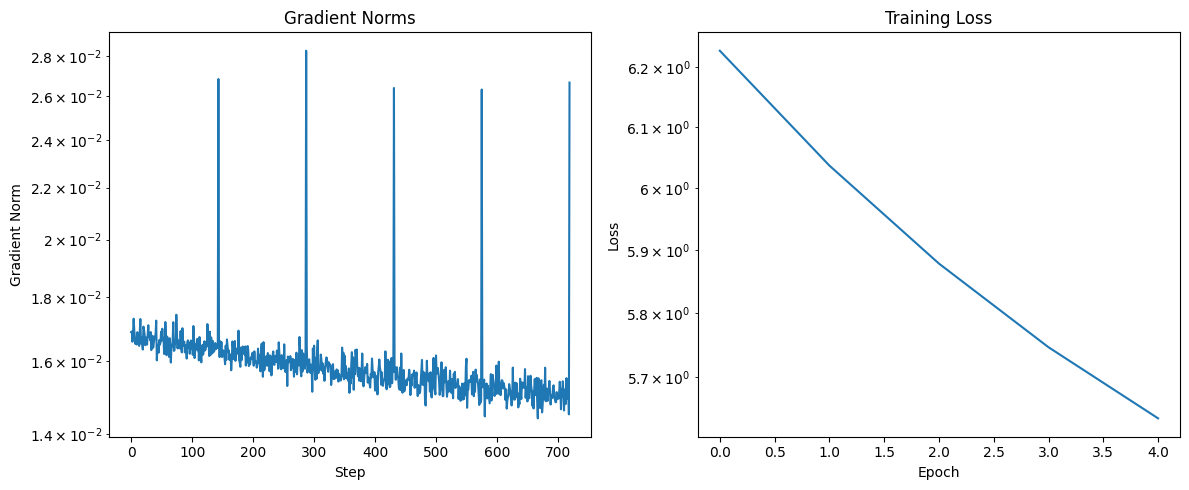

In [104]:
# Plot grads and losses side by side using matplotlib and seaborn
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot grads
sns.lineplot(x=range(len(grads)), y=torch.tensor(grads).tolist(), ax=axes[0])
axes[0].set_title("Gradient Norms")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Gradient Norm")
axes[0].set_yscale('log')  # Set log scale before plotting

# Plot losses
sns.lineplot(x=range(len(losses)), y=losses, ax=axes[1])
axes[1].set_title("Training Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_yscale('log')  # Set log scale before plotting

plt.tight_layout()
plt.show()

In [ ]:
for _ in range(10):
    y = model.generate(torch.ones(1, 1))
    y_str = tokenizer.decode(y[0].tolist())
    print(y_str)

sain man bl pterct9llart!�� vould�adorsit notous,an e For:j andR
 e me you what� have< with�rom bla� andz[gckow she Butlea%meninethce g
 thven Theou G theeceowon on me him withot
starse lF shall.lKher your>�:ot
D heur �ad thou,ri upour
 as
� t c me shehe's this' andceirow we� andQ
 G haeaotherol withet, he,orent thy ourrowatatILessi withong myu heed�Q
 of o�cevener; Butnh's sha theeT nothersel) Thiseour|omeryrand forRX
p garefan by CheeasAR sha!iet be faon�A notl�er youUaan	@ fT
ne4reE myErerINGhich f not his�eaot e his� EIC8ath�it� youus��
anjion se sh. beor youd kn M of of W man was= crow D som m�arir allmedolid
�cei this theees lChuinong� myowOl|;�ri lf
rePer B�ay


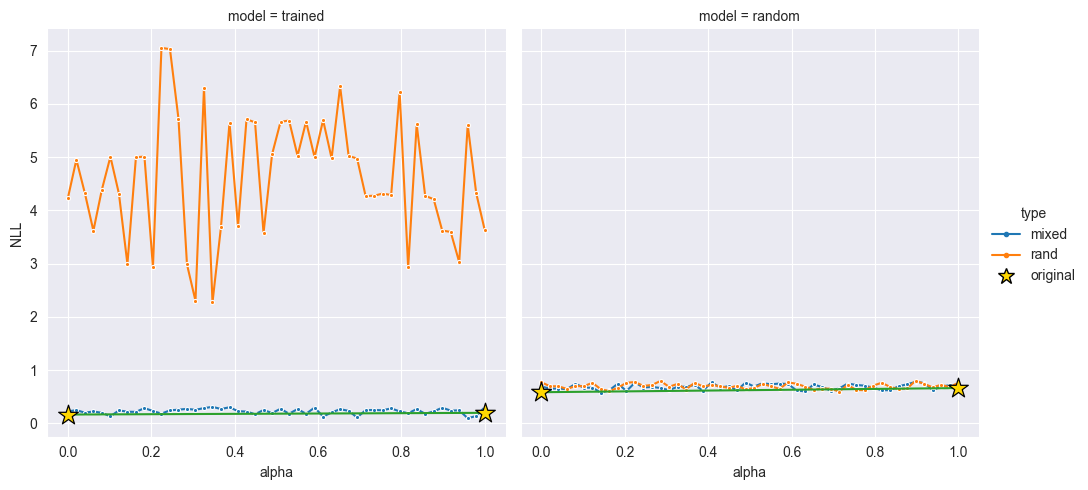

In [ ]:
# Plot likelihoods of all interpolated sentences
sns.set_style("darkgrid")

def merge_vecs(v1, v2, alpha):
    m = torch.rand(len(v1)) < alpha
    return m * v1 + (1 - m.float()) * v2

xa = dataset[0]['input_ids']
xb = dataset[1]['input_ids']

# convert to binary
xa = dec2bin(xa, n_bits_per_token).reshape(-1).to(torch.long)
xb = dec2bin(xb, n_bits_per_token).reshape(-1).to(torch.long)

# Add interpolated xs
xs = []
for alpha in torch.linspace(0, 1, 50):
    x = merge_vecs(xa.float(), xb.float(), alpha).to(torch.long)
    xs.append({'alpha': alpha.item(), 'x': x, 'type': 'mixed'})

# Add random xs
for alpha in torch.linspace(0, 1, 50):
    x = torch.randint(0, 2, (1, seq_len * n_bits_per_token))
    xs.append({'alpha': alpha.item(), 'x': x, 'type': 'rand'})

# Add original xs with special marker type
xs.append({'alpha': 0, 'x': xa, 'type': 'original'})
xs.append({'alpha': 1, 'x': xb, 'type': 'original'})


# Compute NLLs
records = []
for x_dct in xs:
    output = model(torch.ones(1, 1), x_dct['x'].reshape(1, -1))
    records.append({**x_dct, 'nll': output.loss.item(), 'model': 'trained'})
    output_rand = model_rand(torch.ones(1, 1), x_dct['x'].reshape(1, -1))
    records.append({**x_dct, 'nll': output_rand.loss.item(), 'model': 'random'})


# Plot all lines first (no markers)
df = pd.DataFrame(records)

df['NLL'] = df['nll'] + torch.randn(len(df)).numpy() * 0.05
markers = {"mixed": ".", "rand": ".", "original": "*"}

_g = sns.relplot(
    data=df,
    x="alpha",
    y="NLL",
    hue="type",
    style="type",
    col="model",
    kind="line",
    markers=markers,
    dashes=False,
)

# Overlay big stars for originals in the correct facet
for ax, md in zip(_g.axes.flat, _g.col_names):
    d = df[(df["type"] == "original") & (df["model"] == md)]
    ax.scatter(
        d["alpha"], d["NLL"],
        marker="*", s=220, zorder=10,
        facecolor="#FFD700", edgecolor="black", linewidth=0.9,
        label="original"
    )

# Fix legend
if _g._legend:
    for text, handle in zip(_g._legend.texts, _g._legend.legend_handles):
        if text.get_text() == "original":
            handle.set_marker("*")
            handle.set_markersize(12)
            handle.set_markerfacecolor("#FFD700")
            handle.set_markeredgecolor("black")
            handle.set_linestyle("")

# # Make y-axis log scale
# for ax in g.axes.flat:
#     ax.set_yscale('log')

# plt.show()


#### Categorical (Random integers, len=2)

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

class RandomIndexDataset(Dataset):
    def __init__(self, vocab_size, seq_length, num_samples):
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        input_ids = torch.randint(low=0, high=self.vocab_size, size=(self.seq_length,))
        # For categorical tasks, the "target" might just be the input itself or next token, adapt if needed:
        target = input_ids.clone()
        return {'input_ids': input_ids, 'labels': target}


class RandomDiagonalDataset(Dataset):
    def __init__(self, vocab_size, seq_length, num_samples):
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.num_samples = num_samples
        # store sampled values for each sample, later used for diagonal
        self.samples = torch.randint(low=0, high=self.vocab_size, size=(self.num_samples,))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Each element in the sequence is identical, e.g., [0,0] or [1,1], etc.
        value = self.samples[idx].item()
        input_ids = torch.full((self.seq_length,), fill_value=value, dtype=torch.long)
        target = input_ids.clone()
        return {'input_ids': input_ids, 'labels': target}

# Example setup for categorical MPS toy problem:
vocab_size = 10
seq_length = 2
num_samples = 2

dataset = RandomDiagonalDataset(vocab_size, seq_length, num_samples)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Show first few samples
for s in dataset:
    print(s)


{'input_ids': tensor([2, 2]), 'labels': tensor([2, 2])}
{'input_ids': tensor([8, 8]), 'labels': tensor([8, 8])}


In [2]:
# Set random seed for reproducibility
import torch
from ptn.dists import dists
from ptn.dists._abc import AbstractDisributionHeadConfig

# Setup
torch.manual_seed(10)
seq_length = 2
num_samples = 2
d_output = 8

dataset = RandomDiagonalDataset(d_output, seq_length, num_samples)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

def train_mps_sigma_lsf(
    # model configuration
    d_output: int = 16,
    horizon: int = 2,
    rank: int = 4,
    pos_func: str = "abs",
    mode: str = "direct",
    init_method: str = "ortho",
    use_bias: bool = False,

    # training configuration
    lr: float = 1e-3,
    n_epochs: int = 5000,
    **kwargs,
):

    model = dists['mps_sigma_lsf'](
        AbstractDisributionHeadConfig(
            d_model=1,
            d_output=d_output,
            horizon=horizon,
            rank=rank,
            pos_func=pos_func,
            mode=mode,
            init_method=init_method,
            use_bias=use_bias
        )
    )

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    grads = []
    losses = []
    print(f"\n\nTraining model...")
    print(f"Num batches: {len(dataloader)}")
    for epoch in range(n_epochs):
        train_losses = []
        for i, batch in enumerate(dataloader):
            x = batch['input_ids']
            # print(f"x: {x.shape}")
            output = model(torch.ones(x.size(0), 1), x)
            optimizer.zero_grad()
            output.loss.backward()
            optimizer.step()
            grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))
            train_losses.append(output.loss.item())
        loss_avg = sum(train_losses)/len(train_losses)
        losses.append(loss_avg)
        if epoch % 1000 == 0:
            print(f"[Epoch {epoch}/{n_epochs}] Loss: {loss_avg:.2f}")

    return model



In [3]:
exps = [
    {'init_method': 'ortho'},
    {'init_method': 'randn'},
    {'init_method': 'eye'},
]

pys = []
for exp in exps:
    model = train_mps_sigma_lsf(**exp)
    pys.append({**exp, 'p': model.materialize(torch.ones(1, 1)).detach().numpy()[0]})

pys[0]['p'].shape



Training model...
Num batches: 1
[Epoch 0/5000] Loss: 3.21


/var/folders/r_/d81gvkws1n5fg2_7mb57cwzh0000gn/T/ipykernel_76678/2324000913.py:58: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))


[Epoch 1000/5000] Loss: 0.64
[Epoch 2000/5000] Loss: 0.35
[Epoch 3000/5000] Loss: 0.35
[Epoch 4000/5000] Loss: 0.35


Training model...
Num batches: 1
[Epoch 0/5000] Loss: 2.77
[Epoch 1000/5000] Loss: 0.69
[Epoch 2000/5000] Loss: 0.69
[Epoch 3000/5000] Loss: 0.70
[Epoch 4000/5000] Loss: 0.69


/Users/marawangamal/Documents/github/ptn/ptn/dists/mps_sigma_lsf.py:137: UserWarning: Initializing to be all identity will cause degenerate solution. Must use randomness to break symmetry.
  warnings.warn(




Training model...
Num batches: 1
[Epoch 0/5000] Loss: 2.77
[Epoch 1000/5000] Loss: 0.69
[Epoch 2000/5000] Loss: 0.69
[Epoch 3000/5000] Loss: 0.69
[Epoch 4000/5000] Loss: 0.69


(16, 16)

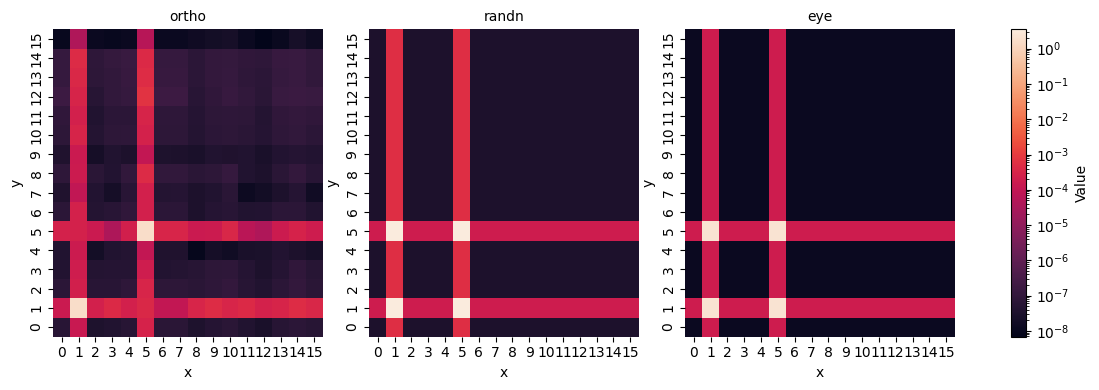

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
import numpy as np

def plot_heatmap_grid(pys, ncols=3):
    # --- Convert all heatmaps to a long-form DataFrame ---
    dfs = []
    for entry in pys:
        p = entry["p"]
        h, w = p.shape
        yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")
        df = pd.DataFrame({
            "x": xx.ravel(),
            "y": yy.ravel(),
            "value": p.ravel(),
            "init_method": entry["init_method"],
        })
        dfs.append(df)
    df_all = pd.concat(dfs, ignore_index=True)

    # --- Compute global limits for shared color scale ---
    vmin = df_all.loc[df_all["value"] > 0, "value"].min()
    vmax = df_all["value"].max()

    # --- Plot with FacetGrid, make the figure smaller ---
    g = sns.FacetGrid(df_all, col="init_method", height=4, sharex=False, sharey=False)

    # --- Invert y-axis for each subplot ---
    for ax in g.axes.flatten():
        ax.invert_yaxis()

    g.map_dataframe(
        lambda data, color=None, **kws: sns.heatmap(
            data.pivot(index="y", columns="x", values="value").iloc[::-1],  # ← flip rows
            cmap="rocket",
            norm=LogNorm(vmin=vmin, vmax=vmax),
            cbar=False,
            **kws
        )
    )

    # Shared colorbar on the right
    sm = plt.cm.ScalarMappable(norm=LogNorm(vmin=vmin, vmax=vmax), cmap="rocket")  # ← and here
    sm.set_array([])
    g.fig.colorbar(sm, ax=g.axes, label="Value", location="right")

    g.set_titles(col_template="{col_name}")
    plt.show()


plot_heatmap_grid(pys)

In [5]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# def plot_small_hist2d(model, d_output, n_test_samples=500, label=None):
#     ys = []
#     for _ in range(n_test_samples):
#         y_i = model.generate_slow_and_unstable(torch.ones(1, 1)).numpy()
#         ys.append(y_i[0])
#     y = np.array(ys)
    
#     plt.figure(figsize=(3, 2))
#     hist = sns.histplot(x=y[:,0], y=y[:,1], bins=[d_output, d_output], cbar=True)
#     if label is not None:
#         plt.title(label)
#     plt.show()
    
# plot_small_hist2d(model, d_output, n_test_samples=50_000, label=f'Trained Model (N={num_samples})')
# plot_small_hist2d(model_rand, d_output, n_test_samples=50_000, label=f'Random Model (N={num_samples})')

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
if hasattr(model, 'materialize'):
    p = model.materialize(torch.ones(1, 1)).reshape(d_output, d_output).detach().numpy()
    plt.figure(figsize=(3, 2))  # Set a small figure size
    # Make (0,0) the bottom left by setting origin='lower'
    ax = sns.heatmap(p, norm=LogNorm())
    ax.invert_yaxis()
    plt.show()

# Print dataloader
for x in dataloader:
    print(x['input_ids'])

RuntimeError: shape '[8, 8]' is invalid for input of size 256

### Simple model

In [ ]:
from typing import Optional
import torch
from dataclasses import dataclass
import numpy as np

# Converts flat indices to multi-index 
def torch_unravel_index(indices, shape):
    id_tuples = np.unravel_index(indices, shape)
    return torch.stack([torch.tensor(t) for t in id_tuples], dim=-1)


class RandomDiagonalDataset(torch.utils.data.Dataset):
    def __init__(self, vocab_size, seq_length, num_samples):
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.num_samples = num_samples
        self.samples = torch.randint(low=0, high=self.vocab_size, size=(self.num_samples,))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Each element in the sequence is identical, e.g., [0,0] or [1,1], etc.
        value = self.samples[idx].item()
        input_ids = torch.full((self.seq_length,), fill_value=value, dtype=torch.long)
        target = input_ids.clone()
        return {'input_ids': input_ids, 'labels': target}

@dataclass
class SimpleModelOutput:
    loss: torch.Tensor

class SimpleModel(torch.nn.Module):
    def __init__(
        self,
        d_output: int,
        rank: int,
        pos_func: str = "abs",
        mode: str = 'factorized',
        pos_func_mode: str = 'factorized',
        rank_dropout: Optional[float] = None  # probability of a rank dim being dropped out
    ):
        super().__init__()
        self.d_output = d_output
        self.rank = rank
        self.rank_dropout = rank_dropout
        self.mode = mode
        self.pos_func = pos_func
        self.pos_func_mode = pos_func_mode

        if self.mode == 'factorized':
            # Decompose into two rank-r matrices
            self._p1 = torch.nn.Parameter(torch.randn(d_output, rank))
            self._p2 = torch.nn.Parameter(torch.randn(rank, d_output))
        elif self.mode == 'full':
            # Model full matrix
            self._p_tilde = torch.nn.Parameter(torch.randn(d_output, d_output))
        else:
            raise ValueError(f"Invalid mode: {self.mode}")
        

    @property
    def p_tilde(self): # Materializes unnormalized dist (d_output, d_output)
        pos_func = {
            "abs": torch.abs,
            "exp": torch.exp,
            "sigmoid": torch.sigmoid,
        }[self.pos_func]
        ids = torch.arange(self.rank)
        if self.rank_dropout is not None:
            n_rank = int(self.rank * self.rank_dropout)
            ids = torch.randperm(self.d_output)
            ids = ids[:n_rank]
        if self.mode == 'factorized':
            if self.pos_func_mode == 'factorized':
                p_tilde = pos_func(self._p1[:, ids]) @ pos_func(self._p2[ids, :])
            else:
                p_tilde = pos_func(self._p1[:, ids] @ self._p2[ids, :])
        elif self.mode == 'full':
            p_tilde = pos_func(self._p_tilde)
        return p_tilde

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Shape of x: (B, 2)
        ids = x[:, 0] * self.d_output + x[:, 1]  # (B,)
        p = self.p_tilde
        loss = p.sum().clamp(min=1e-12).log() - p.reshape(-1)[ids].clamp(min=1e-12).log()
        return loss.sum()

    def sample(self, n_samples: int) -> torch.Tensor:
        p_tilde = self.p_tilde
        p = p_tilde.reshape(-1)
        ids = torch.multinomial(p, n_samples, replacement=True)  # (n_samples,)
        return torch_unravel_index(ids, (self.d_output, self.d_output))

# Setup
torch.manual_seed(12)
num_samples = 2
batch_size = 128
d_output = 16
dataset = RandomDiagonalDataset(d_output, 2, num_samples)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

def train_simple_model(
    # --- Model configuration ---
    d_output: int = 16,
    pos_func: str = "sigmoid",
    mode: str = "factorized",
    pos_func_mode: str = "factorized",
    rank: int = 16,
    rank_dropout: Optional[float] = None,

    # --- Training configuration ---
    n_epochs: int = 20_000,
    lr: float = 1e-3,
    **kwargs,
):
    model = SimpleModel(
        d_output=d_output,
        rank=rank,
        pos_func=pos_func,
        mode=mode,
        pos_func_mode=pos_func_mode,
        rank_dropout=rank_dropout,
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        train_losses = []
        for i, batch in enumerate(dataloader):
            x = batch['input_ids']
            loss = model(x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        loss_avg = sum(train_losses)/len(train_losses)
        if epoch % 5_000 == 0:
            print(f"[Epoch {epoch}/{n_epochs}] Loss: {loss_avg:.2f}")
    return model

In [43]:
exps = [
    # abs
    {'name': 'Factorized (pre $\\sigma$)', 'mode': 'factorized', 'pos_func_mode': 'factorized', 'pos_func': 'abs', 'rank_dropout': 1.0}, 
    {'name': 'Factorized (pre $\\sigma$)', 'mode': 'factorized', 'pos_func_mode': 'factorized', 'pos_func': 'abs', 'rank_dropout': 0.5},
    # {'name': 'Factorized (post $\\sigma$)', 'mode': 'factorized', 'pos_func_mode': 'full', 'pos_func': 'abs'},
    # {'name': 'Full', 'mode': 'full', 'pos_func_mode': 'full', 'pos_func': 'abs'},
    # # sigmoid
    # {'name': 'Factorized (pre $\\sigma$)', 'mode': 'factorized', 'pos_func_mode': 'factorized', 'pos_func': 'sigmoid'}, 
    # {'name': 'Factorized (post $\\sigma$)', 'mode': 'factorized', 'pos_func_mode': 'full', 'pos_func': 'sigmoid'},
    # {'name': 'Full', 'mode': 'full', 'pos_func_mode': 'full', 'pos_func': 'sigmoid'},
    # # exp
    # {'name': 'Factorized (pre $\\sigma$)', 'mode': 'factorized', 'pos_func_mode': 'factorized', 'pos_func': 'exp'}, 
    # {'name': 'Factorized (post $\\sigma$)', 'mode': 'factorized', 'pos_func_mode': 'full', 'pos_func': 'exp'},
    # {'name': 'Full', 'mode': 'full', 'pos_func_mode': 'full', 'pos_func': 'exp'},
]

pys = []
for exp in exps:
    model = train_simple_model(**exp)
    pys.append({**exp, 'p': model.p_tilde.detach().numpy()})

[Epoch 0/20000] Loss: 10.96
[Epoch 5000/20000] Loss: 0.00
[Epoch 10000/20000] Loss: 0.00
[Epoch 15000/20000] Loss: 0.00
[Epoch 0/20000] Loss: 11.44
[Epoch 5000/20000] Loss: 0.02
[Epoch 10000/20000] Loss: 0.01
[Epoch 15000/20000] Loss: 0.01


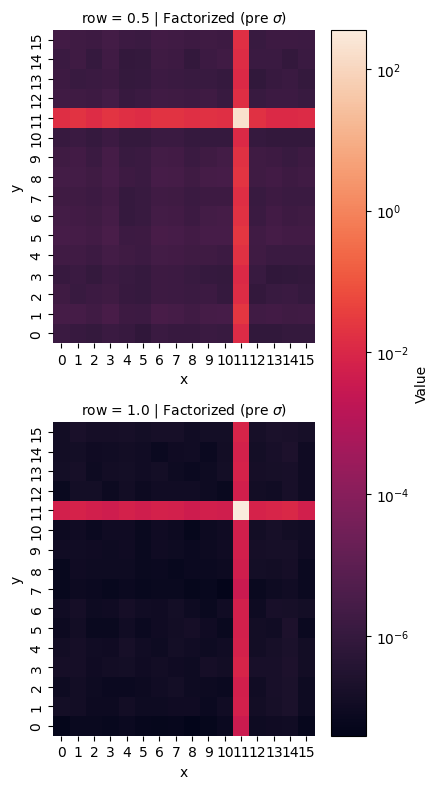

In [45]:
# Helpful grid heatmap plotting function

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LogNorm

def plot_heatmap_grid(pys, value='p', col=None, row=None, log=False):
    # --- Convert all heatmaps to a long-form DataFrame ---
    dfs = []
    for entry in pys:
        h, w = entry[value].shape
        yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")
        additional_cols = {k: entry[v] for k, v in (('col', col), ('row', row)) if v is not None}
        df = pd.DataFrame({
            "x": xx.ravel(),
            "y": yy.ravel(),
            "value": entry[value].ravel(),
            **additional_cols,
        })
        dfs.append(df)
    df_all = pd.concat(dfs, ignore_index=True)

    # --- Compute global limits for shared color scale ---
    vmin = df_all.loc[df_all["value"] > 0, "value"].min()
    vmax = df_all["value"].max()

    # --- Plot with FacetGrid, make the figure smaller ---
    additional_facet_cols = {k: k for k, v in (('col', col), ('row', row)) if v is not None}
    g = sns.FacetGrid(df_all, height=4, sharex=False, sharey=False, **additional_facet_cols)
    g.map_dataframe(
        lambda data, color=None, **kws: sns.heatmap(
            data.pivot(index="y", columns="x", values="value"),
            cmap="rocket",
            norm=LogNorm(vmin=vmin, vmax=vmax) if log else None,
            cbar=False,
            **kws
        )
    )
    for ax in g.axes.flatten():
        ax.invert_yaxis()  # <-- Simple 1-line change to reverse y so (0,0) is bottom left

    # Shared colorbar on the right
    sm = plt.cm.ScalarMappable(norm=LogNorm(vmin=vmin, vmax=vmax) if log else None, cmap="rocket")
    sm.set_array([])
    g.fig.colorbar(sm, ax=g.axes, label="Value", location="right")

    g.set_titles(col_template="{col_name}")
    plt.show()

plot_heatmap_grid(pys, col='name', row='rank_dropout', log=True)


### HMM

#### Helpers

In [88]:
!pip install hmmlearn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [89]:
# Helper functions
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders, processors
import certifi
import os

os.environ["SSL_CERT_FILE"] = certifi.where()

class BPETokenizerWrapper:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.get_vocab_size()
        self.eos_token = "</s>"
        self.pad_token = "<pad>"
        self.eos_token_id = tokenizer.token_to_id(self.eos_token)
        self.pad_token_id = tokenizer.token_to_id(self.pad_token)

    def __len__(self):
        return self.vocab_size

    def encode(self, text, **kwargs):
        return self.tokenizer.encode(text).ids

    def decode(self, ids, skip_special_tokens=True):
        return self.tokenizer.decode(ids)

    def get_vocab_size(self):
        return self.vocab_size


def get_tokenizer(corpus_path, bit_size, n_bits_per_token):
    # You seem to want a specific vocab size tied to your later bin-coding:
    vocab_size = bit_size ** n_bits_per_token  # e.g., 2**8 = 256, 2**16 = 65536

    tok = Tokenizer(models.BPE(unk_token="<unk>"))
    tok.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
    tok.decoder = decoders.ByteLevel()
    tok.post_processor = processors.ByteLevel(trim_offsets=False)

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
        special_tokens=["<pad>", "<unk>", "<s>", "</s>"],
    )

    tok.train([corpus_path], trainer)
    return BPETokenizerWrapper(tok)


file_path = "../data/shakespeare/main.txt"
# Read Shakespeare text
with open(file_path, "r", encoding="utf-8") as f:
    text = f.read()

#### Categorical (Random, Seq len=2)

In [ ]:
import numpy as np

# Hyperparameters
seq_len = 2 
n_features = 8 # Number of possible observations
n_components = 2 # Number of hidden states

# set seed
np.random.seed(12)

# Random dataset
seq1 = np.zeros((seq_len, 1), dtype=int)  # 0 0 0 0 0 0
seq2 = (np.ones((seq_len, 1), dtype=int) * 3).astype(int)   # 3 3 3 3 3 3
X = np.concatenate([seq1, seq2])
lengths = [len(seq1), len(seq2)]    # [6, 6]

In [ ]:
import numpy as np
from hmmlearn.hmm import CategoricalHMM

# Define and fit HMM
model = CategoricalHMM(n_components=n_components, n_features=n_features)
model.fit(X, lengths)

# Print matrix shapes
print("Start probabilities shape:", model.startprob_.shape)
print("Transition matrix shape:", model.transmat_.shape)
print("Emission probabilities shape:", model.emissionprob_.shape)

# Sample new data
X_gen, Z_gen = model.sample(seq_len)
print("Generated observations:", X_gen.ravel())


Fitting a model with 17 free scalar parameters with only 4 data points will result in a degenerate solution.


Start probabilities shape: (2,)
Transition matrix shape: (2, 2)
Emission probabilities shape: (2, 8)
Generated observations: [3 3]


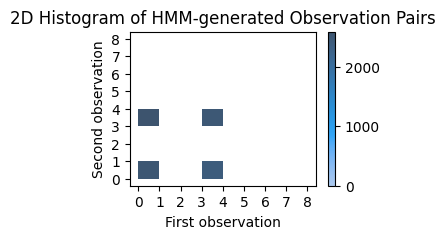

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


# Get samples
n_test_samples = 10_000
xs = []
for i in range(n_test_samples):
    X_gen, Z_gen = model.sample(seq_len)
    xs.append(X_gen.ravel())


# Plot
xs = np.array(xs)
plt.figure(figsize=(3, 2))

bin_edges = np.arange(n_features + 1)
hist = sns.histplot(x=xs[:, 0], y=xs[:, 1], bins=[bin_edges, bin_edges], cbar=True)

plt.xlabel("First observation")
plt.ylabel("Second observation")
plt.title("2D Histogram of HMM-generated Observation Pairs")

# Force integer ticks on both axes
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()


#### Categorical (Shakespeare, Seq len=32)

In [90]:
import numpy as np
from hmmlearn.hmm import CategoricalHMM

# Hyperparameters
n_samples = 1000
seq_len = 32
n_features = 256  # vocab size
n_components = 128  # Number of hidden states

# Get tokenizer
tokenizer = get_tokenizer(file_path, n_features, 1)
tokens = tokenizer.encode(text)
X = np.array(tokens)[:n_samples*seq_len].reshape(-1, 1)
lengths = [seq_len] * n_samples
print(f"Vocab size: {tokenizer.get_vocab_size()}")
print(f"Shape of X: {X.shape}")
print(f"Total tokens: {len(tokens)}")

# Define and fit HMM
model = CategoricalHMM(n_components=n_components, n_features=n_features)
model.fit(X, lengths)

# Sample new data
X_gen, Z_gen = model.sample(seq_len)
print("Generated observations:", X_gen.ravel())


Fitting a model with 49023 free scalar parameters with only 32000 data points will result in a degenerate solution.


Vocab size: 260
Shape of X: (32000, 1)
Total tokens: 1115394
Generated observations: [224  40  53  55  36  47  40  29  36  47  40  29  44  53  44 202  89  81
  68  68  85  72  16  68  81  71 224  75  92 224  68  81]


In [95]:
for _ in range(10):
    X_gen, Z_gen = model.sample(seq_len)
    print(tokenizer.decode(X_gen.ravel()))

u run;
feAm vivd ahane yeu tohal
br
Chitk ktrnr pberenutrt tosny 
h thiel she that hoct bbNoude? 

 t;
ro, on  he tonoof sheuErcg, 
t hoti, witk
m pcoeorvhsg itf bh

rat no co'oy me
ffr.
Bone.
B 
a
 .
Ttheektf nabe anOodi nour osd
t hinl Aes tre tudy poewln; wtnv
lne asg the, ahae woare and lao,
ydogsene, wa, hitn.

CANWIRChs! 


### LSTM Vanishing Gradient

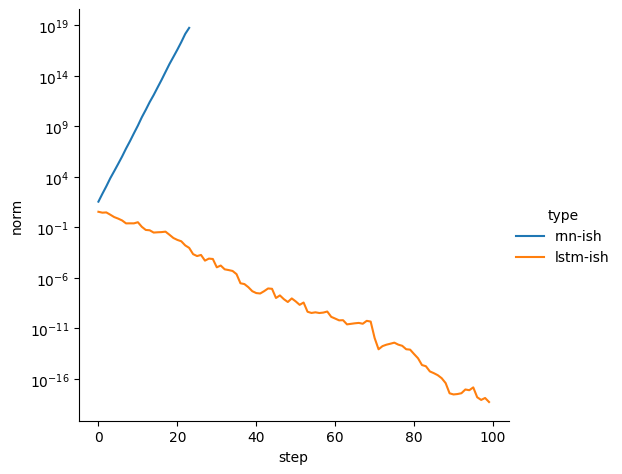

In [159]:
norms = []
n_steps = 100
d_hidden = 32
xn = torch.randn(d_hidden)
for i in range(n_steps):
    xn = torch.randn(d_hidden, d_hidden) @ xn
    norms.append({'step': i, 'norm': torch.norm(xn).item(), 'type': 'rnn-ish'})

xn = torch.randn(d_hidden)
for i in range(n_steps):
    xn = torch.randn(d_hidden) * xn
    norms.append({'step': i, 'norm': torch.norm(xn).item(), 'type': 'lstm-ish'})

df = pd.DataFrame(norms)
sns.relplot(data=df, x='step', y='norm', hue='type', kind='line')
# make log scale
plt.yscale('log')

### Misc

In [ ]:
def get_mnist(n_samples: int = 1000, seq_len: int = 1000, data_dir: str = "./data", scale=None):
    """Create MNIST data loaders with binary thresholding."""
    transform = transforms.Compose([transforms.ToTensor(), lambda x: (x > 0.5).long()])
    if scale is not None:
        transform = transforms.Compose(
            [
                transforms.Resize(
                    (scale, scale)
                ),  # rescale from 28x28 -> (scale, scale)
                transforms.ToTensor(),
                lambda x: (x > 0.5).long(),  # binarize
            ]
        )
    # return torch.randint(0, 2, (n_samples, seq_len)).float()
    train_set = torchvision.datasets.MNIST(
        data_dir, train=True, transform=transform, download=True
    )
    # Give single tensor of shape (n_samples, seq_len)
    return torch.stack([t[0].reshape(-1) for t in train_set])[:n_samples, :seq_len].float()


def get_shakespeare(
    n_samples: int = 1000, 
    seq_len: int = 1000, 
    dataset_path: str = "../data/shakespeare/main.txt", 
    bit_size: int = 2, 
    n_bits_per_token: int = 8
):
    # return torch.randint(0, 2, (n_samples, seq_len)).float()
    tokenizer = get_tokenizer(corpus_path="../data/shakespeare/main.txt", bit_size=bit_size, n_bits_per_token=n_bits_per_token)
    dataset = ShakespeareDataset(tokenizer, seq_len=seq_len, max_samples=n_samples, file_path=dataset_path)
    dataset = torch.stack([t["input_ids"] for t in dataset])[:n_samples]  # (n_samples, seq_len)
    dataset = dec2bin(dataset, n_bits_per_token)
    return dataset.reshape(n_samples, -1)[:, :seq_len].float()


def standardize(dataset: torch.Tensor):
    # Shape: (n_samples, seq_len)
    return (dataset - dataset.mean(dim=0))


# dataset_mnist = get_mnist()
# dataset_shakespeare = get_shakespeare()
# for name, dataset in {"mnist": dataset_mnist, "shakespeare": dataset_shakespeare}.items():
#     print(f"{name} dataset shape: {dataset.shape}")


# datasets = {
#     "mnist": get_mnist(),
#     "shakespeare::2::4": get_shakespeare(bit_size=2, n_bits_per_token=4),
#     "shakespeare::2::8": get_shakespeare(bit_size=2, n_bits_per_token=8),
#     "shakespeare::2::16": get_shakespeare(bit_size=2, n_bits_per_token=16),
# }


In [ ]:
# Hyperparameters
n_samples = 10_000
seq_len = 1000

cols = []
for name, dataset in datasets.items():
    _, s, _ = torch.svd(standardize(dataset))
    cols.append({"dataset": name, "spectrum": s, "index": range(len(s))})

dfs = [pd.DataFrame(col) for col in cols]
df = pd.concat(dfs)

# Use seaborn but assign different markers per dataset using style=
sns.relplot(
    data=df,
    x="index",
    y="spectrum",
    kind="line",
    style="dataset",   # Add marker differentiation by dataset
)
plt.yscale("log")  # Apply log scale to y-axis (may log scale)


Rank dropout PoC

In [35]:
train_simple_model(rank_dropout=0.5)

torch.Size([16, 8]) torch.Size([8, 16])
[Epoch 0/20000] Loss: 11.05
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([16, 8]) torch.Size([8, 16])
torch.Size([

KeyboardInterrupt: 

#### Rank Dropout

In [130]:
from typing import List
from ptn.tensorops.mps import select_margin_mps_tensor_batched

def reconstruct_cores(glist: List[List[torch.Tensor]], rank: int) -> torch.Tensor:
    slct = lambda g, ids: [g[k] for k in ids]
    ids = torch.randperm(len(glist))[:2]
    outlist = []
    for glist_i in slct(glist, ids):
        glist_ii = slct(glist_i, ids)
        outlist.append(torch.stack(glist_ii))
    gtens = torch.stack(outlist)  # (R, R, H, Di, Do)
    # reshape to (H, R, Di, R, Do)
    gtens = gtens.permute(2, 0, 3, 1, 4)
    return gtens


class RDModel(torch.nn.Module):
    def __init__(self, rank: int, rank_dropout: float, horizon: int, d_output: int, d_input: int = 1):
        super().__init__()
        self.rank = rank
        self.rank_dropout = rank_dropout

        # Create parameter list
        self._g = torch.nn.ParameterList()
        for _ in range(rank):
            plist = torch.nn.ParameterList()
            for _ in range(rank):
                plist.append(torch.nn.Parameter(torch.randn(horizon, d_output, d_input)))
            self._g.append(plist)
        self._a = torch.nn.Parameter(torch.randn(rank))
        self._b = torch.nn.Parameter(torch.randn(rank))

    @property
    def g(self) -> torch.Tensor:
        rank_eff = int(self.rank * self.rank_dropout)
        return reconstruct_cores(self._g, rank_eff)

    @property
    def a(self) -> torch.Tensor:
        n_rank = int(self.rank * self.rank_dropout)
        ids = torch.randperm(self.rank)[:n_rank]
        return self._a[ids]

    @property
    def b(self) -> torch.Tensor:
        n_rank = int(self.rank * self.rank_dropout)
        ids = torch.randperm(self.rank)[:n_rank]
        return self._b[ids]



    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # x: (B, d_input)
        # y: (B, d_output)
        B = x.size(0)
        g = torch.einsum('hpoqi,bi->bhpoq', self.g, x)
        a = self.a.reshape(1, -1).expand(B, -1)
        b = self.b.reshape(1, -1).expand(B, -1)
        res = select_margin_mps_tensor_batched(a, b, g, y)
        return res


In [ ]:
batch_size, rank, rank_dropout, horizon, d_input, d_output = 4, 4, 0.5, 3, 1, 8
model = RDModel(rank=rank, rank_dropout=rank_dropout, horizon=horizon, d_output=d_output)
x, y = torch.ones(batch_size, d_input), torch.randint(0, d_output, (batch_size, horizon))
len(model(x, y))

2

In [ ]:
!pip install --upgrade pip
!pip install git+https://github.com/bdusell/semiring-einsum.git

In [123]:
import torch_semiring_einsum as ts

ts.log_einsum('ij,j->i', torch.randn(2, 3), torch.randn(3))

AttributeError: 'str' object has no attribute 'validate_sizes'